In [1]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 5.6 MB/s eta 0:00:0000:0100:01m
Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2 as cv2
import skimage.morphology as morph

In [4]:
import os

# Vérifier si le dossier existe, sinon le créer
if not os.path.exists('data'):
    os.makedirs('data')

if not os.listdir('data'):
    %cd data
    !unzip -n ../meteor.zip
    %cd ..

data/meteor/20160811_000103_487_700_766_1250_1358.tif: (66, 108), float64, -25.0, 210.66666666666666


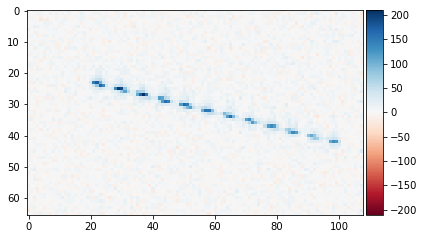

data/meteor/20140928_221255_358_501_572_731_789.tif: (71, 58), float64, -23.0, 48.888888888888886


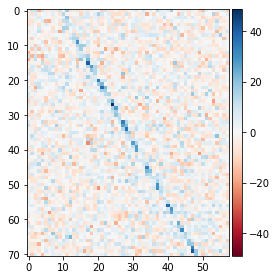

data/meteor/20141024_043613_079_302_410_683_835.tif: (108, 152), float64, -234.33333333333331, 362.6666666666667


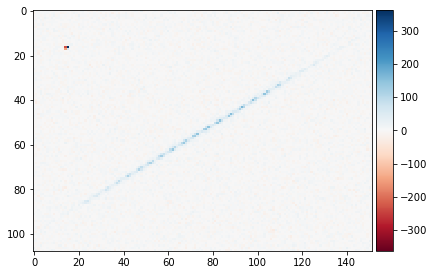

data/meteor/20160813_030839_167_594_677_684_791.tif: (83, 107), float64, -153.0, 122.33333333333331


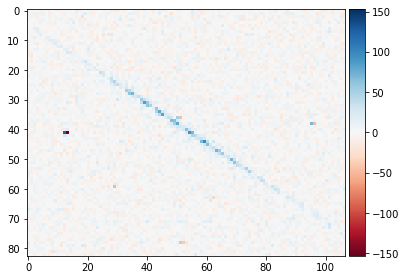

data/meteor/20170105_005741_194_112_210_335_640.tif: (98, 305), float64, -131.77777777777783, 301.0


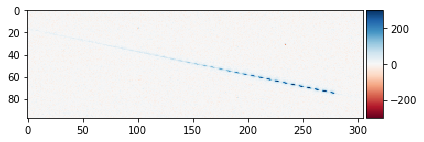

In [5]:
from skimage import io

folder_path = 'data/meteor'

i = 0
for filename in os.listdir(folder_path):
    if filename.endswith('.tif'):
        file_path = os.path.join(folder_path, filename)
        
        image = io.imread(file_path)

        if (i < 5):
            print(f"{file_path}: {image.shape}, {image.dtype}, {image.min()}, {image.max()}")
            io.imshow(image)
            io.show()
            i += 1

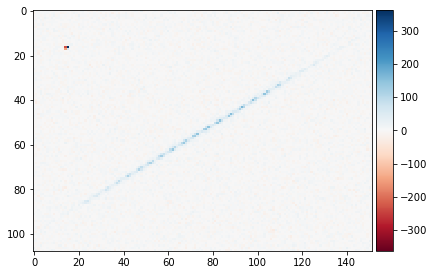

In [116]:
img = io.imread("data/meteor/20141024_043613_079_302_410_683_835.tif")
io.imshow(img)
io.show()

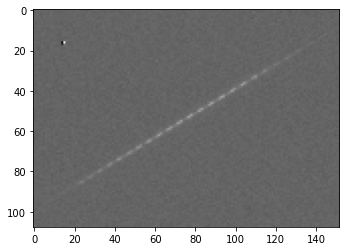

In [117]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(img, cmap='gray')
plt.show()

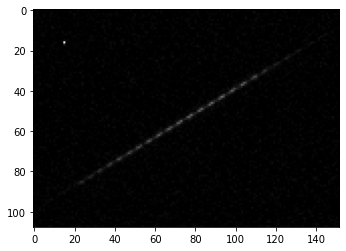

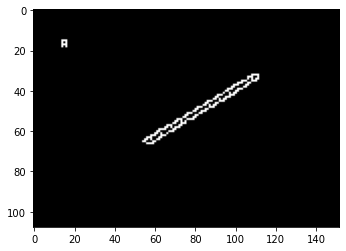

In [120]:
# Eliminer les valeurs négatives
img[img < 0] = 0

# Normaliser l'image dans la plage de 0 à 255
img = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)

plt.imshow(img, cmap='gray')
plt.show()

img_blurred = cv2.GaussianBlur(img, (5, 5), 0)

# Détection des contours à l'aide de l'algorithme de Canny
edges = cv2.Canny(img_blurred, 50, 150)

plt.imshow(edges, cmap='gray')
plt.show()

In [86]:
# Détection des lignes à l'aide de la transformée de Hough probabiliste
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180,
                        threshold=100)

print(lines)

[[[ 71  58  75  55]]

 [[ 77  54 102  39]]]


In [87]:
# Si des lignes ont été détectées
if lines is not None:
    l = len(lines)
    # Convertir les coordonnées des lignes en une représentation plus pratique
    lines = lines.squeeze()
    if l == 1:
        lines = np.array([lines])
    print(lines)

[[ 71  58  75  55]
 [ 77  54 102  39]]


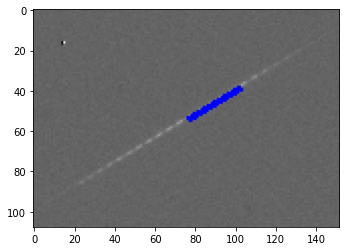

In [89]:
if lines is not None:
    # Sélectionner la ligne la plus longue
    longest_line = max(
        lines, key=lambda line: (line[2] - line[0])**2 + (line[3] - line[1])**2)

    # Dessiner la ligne détectée sur l'image originale (en rouge)
    x1, y1, x2, y2 = longest_line
    # Convertir en image couleur pour le dessin
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.line(img_color, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # Afficher l'image avec la ligne détectée
    plt.imshow(img_color)
    plt.show()

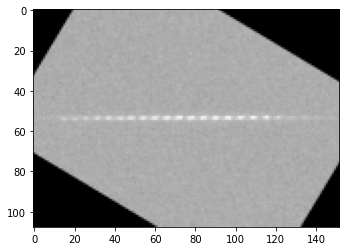

In [90]:
if lines is not None:
    dx = x2 - x1
    dy = y2 - y1
    angle_radians = np.arctan2(dy, dx)
    angle_degrees = np.degrees(angle_radians)
    
    rows, cols = img.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle_degrees, 1)
    rotated_img = cv2.warpAffine(img, rotation_matrix, (cols, rows))
    
    plt.imshow(rotated_img, cmap='gray')
    plt.show()

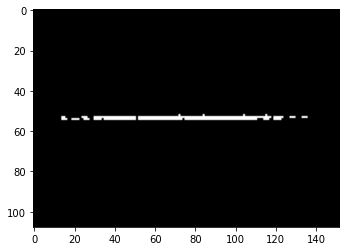

In [94]:
if lines is not None:
    bin_img = (rotated_img > 110).astype(np.uint8)
    
    plt.imshow(bin_img, cmap='gray')
    plt.show()

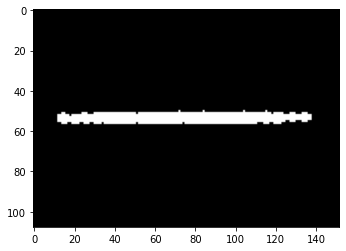

In [95]:
if lines is not None:
    kernel_size = 5
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    dilated_img = cv2.dilate(bin_img, kernel)

    # Afficher l'image dilatée
    plt.imshow(dilated_img, cmap='gray')
    plt.show()

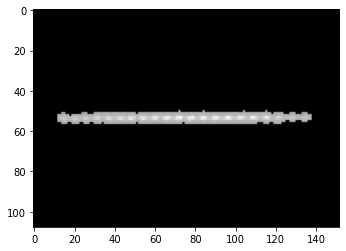

In [96]:
if lines is not None:
    num_labels, labels = cv2.connectedComponents(dilated_img)

    # Identifier la composante connexe la plus grande
    largest_component_label = np.argmax(np.bincount(labels.flat)[1:]) + 1

    # Créer une masque pour la composante la plus grande
    largest_component_mask = (
        labels == largest_component_label).astype(np.uint8) * 255

    # Appliquer la masque à l'image binaire pour ne garder que la composante la plus grande
    largest_component_image = cv2.bitwise_and(
        rotated_img, largest_component_mask)
    
    plt.imshow(largest_component_image, cmap='gray')
    plt.show()

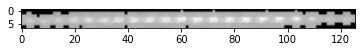

In [97]:
if lines is not None:
    x, y, w, h = cv2.boundingRect(largest_component_mask)

    # Recadrer l'image pour se concentrer sur la zone du masque
    cropped_image = largest_component_image[y:y+h, x:x+w]

    plt.imshow(cropped_image, cmap='gray')
    plt.show()